In [55]:
import tensorflow as tf
import numpy as np
from six.moves import cPickle as pickle
import skimage.io
#from misc import *
from scipy.misc import imresize
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import os

In [2]:
NUM_CLASSES = 28 #27 types of logos +1 for background
BATCH_SIZE = 64
TRAIN_SIZE = 70000
VALID_SIZE = 5000
TEST_SIZE = 5000
CLASS_NAME = [
    'Adidas', 'Apple', 'BMW', 'Citroen', 'Cocacola', 'DHL', 'Fedex', 'Ferrari',
    'Ford', 'Google', 'HP', 'Heineken', 'Intel', 'McDonalds', 'Mini', 'Nbc',
    'Nike', 'Pepsi', 'Porsche', 'Puma', 'RedBull', 'Sprite', 'Starbucks',
    'Texaco', 'Unicef', 'Vodafone', 'Yahoo', 'Background'
]

In [3]:
def forward_pass(x,y):
    #Xavier Initializer to get better initialization of weights of the network
    initializer = tf.contrib.layers.xavier_initializer()
    #Convolutional Layers
    a1 = tf.layers.conv2d(x,32,3,padding = 'SAME',activation=tf.nn.relu,kernel_initializer=initializer)
    p1 = tf.nn.max_pool(a1,[1,2,2,1],[1,2,2,1],padding='SAME')
    a2 = tf.layers.conv2d(p1,64,3,padding='SAME',activation=tf.nn.relu,kernel_initializer=initializer)
    p2 = tf.nn.max_pool(a2,[1,2,2,1],[1,2,2,1],padding = 'SAME')
    a3 = tf.layers.conv2d(p2,128,3,padding='SAME',activation=tf.nn.relu,kernel_initializer=initializer)
    p3 = tf.nn.max_pool(a3,[1,2,2,1],[1,2,2,1],padding = 'SAME')
    #Fully Connected Layers
    flat = tf.contrib.layers.flatten(p3)
    d1 = tf.layers.dense(flat,2048,activation = tf.nn.relu)
    d2 = tf.layers.dense(d1,NUM_CLASSES)
    preds = tf.nn.softmax(d2)
    #Loss
    loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=d2,labels=y))
    
    return preds,loss

In [4]:
def get_solver(lr):
    return tf.train.AdamOptimizer(learning_rate=lr)

In [6]:
with open('deep_logo.pickle','rb') as pk:
    pick = pickle.load(pk)
    train_dataset = pick['train_dataset']
    train_labels = pick['train_labels']
    valid_dataset = pick['valid_dataset']
    valid_labels = pick['valid_labels']
    test_dataset = pick['test_dataset']
    test_labels = pick['test_labels']
    del pick
    print('Training set', train_dataset.shape, train_labels.shape)
    print('Valid set', valid_dataset.shape, valid_labels.shape)
    print('Test set', test_dataset.shape, test_labels.shape)


Training set (70000, 32, 64, 3) (70000,)
Valid set (5000, 32, 64, 3) (5000,)
Test set (5000, 32, 64, 3) (5000,)


In [5]:
input_pl = tf.placeholder(tf.float32, shape = [None,32,64,3])
output_pl = tf.placeholder(tf.int32,shape = [None])

In [6]:
preds,loss = forward_pass(input_pl,output_pl)
solver = get_solver(0.0001)
train_step =solver.minimize(loss)

In [7]:
loss.shape

TensorShape([])

In [8]:
def train(input_pl, output_pl, train_step,loss,preds, num_epochs=10,print_every=100):
    iter_per_epoch = TRAIN_SIZE//BATCH_SIZE
    with tf.Session() as sess:
        saver = tf.train.Saver()
        sess.run(tf.global_variables_initializer())
        ckpt = tf.train.latest_checkpoint("checkpoints/")
        if ckpt:
            print("Loading model checkpoint...")
            saver.restore(sess,ckpt)
        else:
            print("No checkpoint found")
            
        for i in range(num_epochs):
            batch = 0
            for j in range(iter_per_epoch):
                x_batch = train_dataset[batch:(batch+BATCH_SIZE)%TRAIN_SIZE]
                y_batch = train_labels[batch:(batch+BATCH_SIZE)%TRAIN_SIZE]
                feed_dict = {input_pl:x_batch,output_pl:y_batch}
                train_loss,_ = sess.run([loss,train_step],feed_dict)
                if (j+1)%print_every==0:
                    print("Epoch ",i," Iteration ",j,"Loss: ",train_loss)
                    
                batch += BATCH_SIZE
            saver.save(sess,'checkpoints/logo')
            #Testing on validation set
            iters = VALID_SIZE//BATCH_SIZE
            batch = 0
            avg_accuracy = 0
            for j in range(iters):
                val_x_batch = valid_dataset[batch:(batch+BATCH_SIZE)%VALID_SIZE]
                val_y_batch = valid_labels[batch:(batch+BATCH_SIZE)%VALID_SIZE]
                feed_dict = {input_pl: val_x_batch, output_pl: val_y_batch}
                val_preds = sess.run(preds,feed_dict)
                val_preds = np.argmax(val_preds,axis = 1)
                accuracy = np.mean(val_preds==val_y_batch)
                avg_accuracy += accuracy
            avg_accuracy = avg_accuracy/iters;
            print(avg_accuracy)

In [71]:
train(input_pl,output_pl,train_step,loss,preds)

Loading model checkpoint...
INFO:tensorflow:Restoring parameters from checkpoints/logo
Epoch  0  Iteration  99 Loss:  1.77505
Epoch  0  Iteration  199 Loss:  1.40012
Epoch  0  Iteration  299 Loss:  0.932979
Epoch  0  Iteration  399 Loss:  0.576982
Epoch  0  Iteration  499 Loss:  0.509377
Epoch  0  Iteration  599 Loss:  0.350101
Epoch  0  Iteration  699 Loss:  0.322804
Epoch  0  Iteration  799 Loss:  0.15933
Epoch  0  Iteration  899 Loss:  0.114658
Epoch  0  Iteration  999 Loss:  0.154682
0.9375
Epoch  1  Iteration  99 Loss:  0.177463
Epoch  1  Iteration  199 Loss:  0.406561
Epoch  1  Iteration  299 Loss:  0.0994828
Epoch  1  Iteration  399 Loss:  0.142492
Epoch  1  Iteration  499 Loss:  0.160428
Epoch  1  Iteration  599 Loss:  0.134906
Epoch  1  Iteration  699 Loss:  0.131855
Epoch  1  Iteration  799 Loss:  0.0622789
Epoch  1  Iteration  899 Loss:  0.0336238
Epoch  1  Iteration  999 Loss:  0.0327782
0.953125
Epoch  2  Iteration  99 Loss:  0.0602654
Epoch  2  Iteration  199 Loss:  0.233

In [45]:
def iou(box1, box2):
    x11,y11,x21,y21 = box1
    x12,y12,x22,y22 = box2
    x1 = max(x11,x12)
    y1 = max(y11,y12)
    x2 = min(x21,x22)
    y2 = min(y21,y22)
    inter_area = (x2-x1)*(y2-y1)
    box1_area = (x21-x11)*(y21-y11)
    box2_area = (x22-x12)*(y22-y12)
    union_area = box1_area + box2_area - inter_area
    iou = inter_area/union_area
    return iou

def get_sorted_idx(results):
    prob = np.array([result['prob'] for result in results])
    idx = np.argsort(prob)[::-1]
    return idx

def nms(results, prob_thresh, min_iou):
    thres_results = []
    for i in range(len(results)):
        if(results[i]['prob'] > prob_thresh):
            thres_results.append(results[i])

    nms_results = []
    if(len(thres_results) == 0):
        return thres_results
    thres_results = np.array(thres_results)
    idx = get_sorted_idx(thres_results)
    thres_results = thres_results[idx]
    max_prob_result = thres_results[0]
    nms_results.append(max_prob_result)
    thres_results = thres_results[1:]

    idx = get_sorted_idx(thres_results)
    thres_results = thres_results[idx]

    while(len(thres_results) > 0):
        candidates = []
        for i in range(len(thres_results)):
            x1,y1,w1,h1 = thres_results[i]['region']
            x2,y2,w2,h2 = max_prob_result['region']
            if(iou((x1,y1,x1+w1,y1+h1),(x2,y2,x2+w2,y2+h2)) < min_iou):
                print(iou((x1,y1,x1+w1,y1+h1),(x2,y2,x2+w2,y2+h2)))
                candidates.append(thres_results[i])

        if(len(candidates) == 0):
            print("hello")
            break

        candidates = np.array(candidates)
        idx = get_sorted_idx(candidates)
        candidates = candidates[idx]
        max_prob_result = candidates[0]
        thres_results = candidates[1:]
        if(len(thres_results) ==0):
            break
        nms_results.append(max_prob_result)

    return nms_results

In [147]:
def logo_recognition(sess, img, obj_proposal,input_pl,preds):
    recog_results = {}
    recog_results['region'] = obj_proposal
    img = scale(img)

    pred = sess.run(
        [preds], feed_dict={input_pl: img})
    recog_results['pred_class'] = CLASS_NAME[np.argmax(pred)]
    recog_results['prob'] = np.max(pred)
    return recog_results

def detect_logos(images,input_pl,preds,sess):
    for image in images:
        img = skimage.io.imread(image)
        img = img[:,:,0:3]
        print(img.shape)
        proposals = list(get_region_proposals(img))
        preds_prob = []
        preds_label = []
        results =[]
        for region in proposals:
            x,y,w,h = region
            crop_img = img[y:y+h,x:x+w]
            crop_img = imresize(crop_img,(32,64,3),interp='bicubic')
            crop_img = crop_img[None,:]
            results.append(
                logo_recognition(sess, crop_img, region,input_pl,preds))

        del_idx = []
        for i, result in enumerate(results):
            if result['pred_class'] == CLASS_NAME[-1]:
                del_idx.append(i)
        results = np.delete(results, del_idx)
        nms_results = nms(list(results),0.6,0.1)
        fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
        ax.imshow(img)

        for result in nms_results:
            (x, y, w, h) = result['region']
            ax.text(
                x,
                y,
                result['pred_class'],
                fontsize=13,
                bbox=dict(facecolor='blue', alpha=0.7))
            rect = mpatches.Rectangle(
                (x, y), w, h, fill=False, edgecolor='blue', linewidth=5)
            ax.add_patch(rect)
        plt.savefig('results/' + image[len('test_images/'):], bbox_inches='tight')
        plt.close(fig)

In [148]:
images = os.listdir("test_images")
images = ['test_images/'+image for image in images]

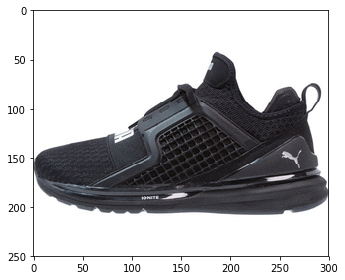

In [149]:
skimage.io.imshow(images[0])
plt.show()

In [150]:
images

['test_images/puma-ignite-limitless-black.png',
 'test_images/2180367311_Google.png',
 'test_images/6651198_McDonalds.png',
 'test_images/401253895_BMW.png',
 'test_images/4273898682_DHL.png',
 'test_images/puma-logo.jpg',
 'test_images/3907703753_Fedex.png',
 'test_images/3666600356_Cocacola.png']

In [151]:
with tf.Session() as sess:
    saver = tf.train.Saver()
    sess.run(tf.global_variables_initializer())
    ckpt = tf.train.latest_checkpoint("checkpoints/")
    if ckpt:
        print("Loading model checkpoint...")
        saver.restore(sess,ckpt)
    else:
        print("No checkpoint found")
    detect_logos(images,input_pl,preds,sess)

Loading model checkpoint...
INFO:tensorflow:Restoring parameters from checkpoints/logo
(250, 300, 3)
(401, 472, 3)
(365, 472, 3)
hello
(448, 472, 3)
hello
(317, 472, 3)
hello
(960, 1280, 3)
0.0
0.0
hello
(326, 472, 3)
hello
(424, 472, 3)
-0.3972413793103448
